In [ ]:
# εντολές για να γίνει mount τα αρχεία του drive μας, ώστε να μπορούμε να έχουμε πρόσβαση από το google colab
from  google.colab  import  drive 
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
# λήψη της βιβλιοθήκης darts
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 16.0 MB/s 
     |████████████████████████████████| 1.9 MB 53.4 MB/s 
     |████████████████████████████████| 575 kB 38.8 MB/s 
     |████████████████████████████████| 800 kB 67.1 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
     |████████████████████████████████| 9.9 MB 58.4 MB/s 
     |████████████████████████████████| 91 kB 12.3 MB/s 
     |████████████████████████████████| 9.4 MB 64.5 MB/s 
     |████████████████████████████████| 1.6 MB 44.7 MB/s 
     |████████████████████████████████| 965 kB 62.3 MB/s 
     |████████████████████████████████| 295 kB 58.7 MB/s 
     |████████████████████████████████| 512 kB 59.1 MB/s 
     |████████████████████████████████| 125 kB 71.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    

# Without using External Data

In [ ]:
# απαραίτητες βιβλιοθήκες για την υλοποίηση του forecasting
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing

In [ ]:
# ανάγνωση δεδομένων
greece_inflation = pd.read_csv('/content/drive/MyDrive/ΔΙΠΛΩΜΑΤΙΚΗ/Inflation and Parameters.csv')
greece_inflation.head()

Date       Cpi  Food Price Index  Energy Price Index      Hicp  \
0  2001-01-01  0.001806          0.016060            0.111474  0.003837   
1  2001-02-01  0.000000          0.011688            0.097947  0.000000   
2  2001-03-01  0.036626          0.008565            0.077760  0.042722   
3  2001-04-01  0.054424          0.003301            0.082858  0.063443   
4  2001-05-01  0.062677          0.009190            0.087208  0.072909   

   Unemployment Rate       Gdp  Rent Price  House Prices       Lci  
0           0.109312  0.000000    0.000000      0.315560  0.000000  
1           0.110324  0.005330    0.006099      0.328415  0.017084  
2           0.110324  0.010660    0.012198      0.341270  0.034167  
3           0.118421  0.015991    0.018297      0.354126  0.051251  
4           0.117409  0.029163    0.025907      0.352209  0.054301

In [ ]:
greece_inflation.shape

(256, 10)

In [ ]:
# ορισμός χρονοσειράς
series = TimeSeries.from_dataframe(greece_inflation, 'Date', 'Cpi')

In [ ]:
# train και validation split στα δεδομένα
train, val = series.split_after(200)

In [ ]:
# εφαρμογή του μοντέλου για την πρόβλεψη
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

In [ ]:
pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 18.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.22.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


Text(0.5, 0, 'Year')

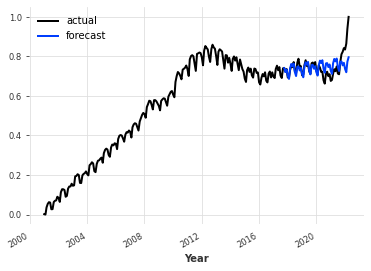

In [ ]:
# plot διαγράμματος των πραγματικών και των προβλέψιμων τιμών
import matplotlib.pyplot as plt

series.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Year')

In [ ]:
# Υπολογισμός του Mean Absolute Error
from statsmodels.tools.eval_measures import meanabs
error = meanabs(prediction, val)
print("MAE is ",error)

/usr/local/lib/python3.8/dist-packages/statsmodels/tools/eval_measures.py:152: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  x1 = np.asanyarray(x1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tools/eval_measures.py:153: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  x2 = np.asanyarray(x2)


MAE is  [[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[<TimeSeries (DataArray) (Date: 1, component: 1, sample: 1)>
                               array([[[0.03373507]]])
                               Coordinates:
                                 * Date       (Date) datetime64[ns] 2017-10-01
                                 * component  (component) object 'Cpi'
                               Dimensions without coordinates: sample
                               Attributes:
                                   static_covariates:  None
                                   hierarchy:          None                               ]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]


# Using External Data

In [ ]:
# Εισαγωγή απαραιτήτων βιβλιοθηκών
from darts.models import BlockRNNModel
from darts.metrics import rmse

In [ ]:
# Δημιουργία χρονοσειρών
cpi_series = TimeSeries.from_dataframe(greece_inflation, 'Date', 'Cpi')

In [ ]:
def eval_model(model, past_covariates=None, future_covariates=None):
    
    # Οι παρελθοντικές και οι μελλοντικές συμμεταβλητές είναι προαιρετικές 
    # επειδή δεν θα χρησιμοποιούνται πάντα στις δοκιμές μας
    backtest = model.historical_forecasts(series=cpi_series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=6)
    
    cpi_series[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=6)')
    print('Backtest RMSE = {}'.format(rmse(cpi_series, backtest)))

In [ ]:
# Επιλέγουμε την χρονοσειρά Lci ως εξωτερική για την επίτευξη της πρόβλεψης
external_series = TimeSeries.from_dataframe(greece_inflation, 'Date', 'Lci')

In [ ]:
# ορισμός και fit μοντέλου
brnn_no_cov = BlockRNNModel(input_chunk_length=30, output_chunk_length=10, n_rnn_layers=2)
brnn_no_cov.fit(cpi_series, past_covariates=external_series, epochs=1000, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


  0%|          | 0/47 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  4%|▍         | 2/47 [00:00<00:03, 14.10it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  9%|▊         | 4/47 [00:00<00:03, 13.31it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 13%|█▎        | 6/47 [00:00<00:03, 13.30it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 17%|█▋        | 8/47 [00:00<00:02, 13.62it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 21%|██▏       | 10/47 [00:00<00:02, 13.75it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 26%|██▌       | 12/47 [00:00<00:02, 12.68it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 30%|██▉       | 14/47 [00:01<00:02, 12.10it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 34%|███▍      | 16/47 [00:01<00:02, 11.68it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 38%|███▊      | 18/47 [00:01<00:02, 11.38it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 43%|████▎     | 20/47 [00:01<00:02, 10.95it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 47%|████▋     | 22/47 [00:01<00:02, 11.11it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 51%|█████     | 24/47 [00:01<00:01, 11.50it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 55%|█████▌    | 26/47 [00:02<00:01, 11.89it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 60%|█████▉    | 28/47 [00:02<00:01, 12.01it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 64%|██████▍   | 30/47 [00:02<00:01, 12.41it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 68%|██████▊   | 32/47 [00:02<00:01, 12.85it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 72%|███████▏  | 34/47 [00:02<00:01, 12.49it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 77%|███████▋  | 36/47 [00:02<00:00, 12.14it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 81%|████████  | 38/47 [00:03<00:00, 12.44it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 85%|████████▌ | 40/47 [00:03<00:00, 12.67it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 89%|████████▉ | 42/47 [00:03<00:00, 12.49it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 94%|█████████▎| 44/47 [00:03<00:00, 12.76it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 98%|█████████▊| 46/47 [00:03<00:00, 12.84it/s]

Predicting: 7it [00:00, ?it/s]

100%|██████████| 47/47 [00:03<00:00, 12.37it/s]


Backtest RMSE = 0.06091948359191901


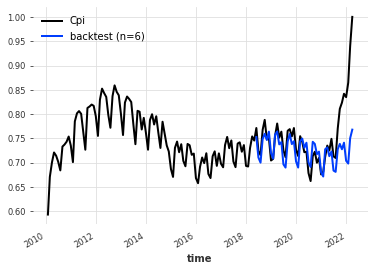

In [ ]:
# αξιολόγιση μοντέλων
eval_model(brnn_no_cov, external_series)

In [ ]:
cols = ['Food Price Index', 'Energy Price Index',	'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
  0%|          | 0/47 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  4%|▍         | 2/47 [00:00<00:03, 11.66it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  9%|▊         | 4/47 [00:00<00:03, 10.97it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 13%|█▎        | 6/47 [00:00<00:03, 11.24it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 17%|█▋        | 8/47 [00:00<00:03, 11.24it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 21%|██▏       | 10/47 [00:00<00:03, 11.37it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 26%|██▌       | 12/47 [00:01<00:02, 11.86it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 30%|██▉       | 14/47 [00:01<00:02, 12.18it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 34%|███▍      | 16/47 [00:01<00:02, 12.49it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 38%|███▊      | 18/47 [00:01<00:02, 12.47it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 43%|████▎     | 20/47 [00:01<00:02, 12.77it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 47%|████▋     | 22/47 [00:01<00:01, 12.86it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 51%|█████     | 24/47 [00:01<00:01, 12.80it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 55%|█████▌    | 26/47 [00:02<00:01, 13.14it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 60%|█████▉    | 28/47 [00:02<00:01, 13.30it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 64%|██████▍   | 30/47 [00:02<00:01, 13.26it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 68%|██████▊   | 32/47 [00:02<00:01, 13.47it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 72%|███████▏  | 34/47 [00:02<00:00, 13.49it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 77%|███████▋  | 36/47 [00:02<00:00, 13.58it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 81%|████████  | 38/47 [00:02<00:00, 13.31it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 85%|████████▌ | 40/47 [00:03<00:00, 13.54it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 89%|████████▉ | 42/47 [00:03<00:00, 13.54it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 94%|█████████▎| 44/47 [00:03<00:00, 12.94it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 98%|█████████▊| 46/47 [00:03<00:00, 12.54it/s]

Predicting: 7it [00:00, ?it/s]

100%|██████████| 47/47 [00:03<00:00, 12.61it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Backtest RMSE = 0.06133965389211353


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
  0%|          | 0/47 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  4%|▍         | 2/47 [00:00<00:03, 13.02it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  9%|▊         | 4/47 [00:00<00:03, 13.39it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 13%|█▎        | 6/47 [00:00<00:03, 13.64it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 17%|█▋        | 8/47 [00:00<00:02, 13.79it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 21%|██▏       | 10/47 [00:00<00:02, 13.92it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 26%|██▌       | 12/47 [00:00<00:02, 13.91it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 30%|██▉       | 14/47 [00:01<00:02, 13.78it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 34%|███▍      | 16/47 [00:01<00:02, 12.83it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 38%|███▊      | 18/47 [00:01<00:02, 12.85it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 43%|████▎     | 20/47 [00:01<00:02, 12.96it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 47%|████▋     | 22/47 [00:01<00:01, 13.21it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 51%|█████     | 24/47 [00:01<00:01, 13.54it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 55%|█████▌    | 26/47 [00:01<00:01, 13.67it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 60%|█████▉    | 28/47 [00:02<00:01, 13.74it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 64%|██████▍   | 30/47 [00:02<00:01, 13.56it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 68%|██████▊   | 32/47 [00:02<00:01, 13.48it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 72%|███████▏  | 34/47 [00:02<00:00, 13.60it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 77%|███████▋  | 36/47 [00:02<00:00, 13.87it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 81%|████████  | 38/47 [00:02<00:00, 14.11it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 85%|████████▌ | 40/47 [00:02<00:00, 14.25it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 89%|████████▉ | 42/47 [00:03<00:00, 14.42it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 94%|█████████▎| 44/47 [00:03<00:00, 14.14it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 98%|█████████▊| 46/47 [00:03<00:00, 13.48it/s]

Predicting: 7it [00:00, ?it/s]

100%|██████████| 47/47 [00:03<00:00, 13.62it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Backtest RMSE = 0.06175849295646611


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
  0%|          | 0/47 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  4%|▍         | 2/47 [00:00<00:03, 12.25it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  9%|▊         | 4/47 [00:00<00:03, 12.51it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 13%|█▎        | 6/47 [00:00<00:03, 12.15it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 17%|█▋        | 8/47 [00:00<00:03, 12.00it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 21%|██▏       | 10/47 [00:00<00:03, 12.15it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 26%|██▌       | 12/47 [00:00<00:02, 12.36it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 30%|██▉       | 14/47 [00:01<00:02, 12.46it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 72%|███████▏  | 34/47 [00:02<00:01, 12.28it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 77%|███████▋  | 36/47 [00:02<00:00, 12.34it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 81%|████████  | 38/47 [00:03<00:00, 12.05it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 85%|████████▌ | 40/47 [00:03<00:00, 11.97it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 89%|████████▉ | 42/47 [00:03<00:00, 11.98it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 94%|█████████▎| 44/47 [00:03<00:00, 11.96it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 98%|█████████▊| 46/47 [00:03<00:00, 12.36it/s]

Predicting: 7it [00:00, ?it/s]

100%|██████████| 47/47 [00:03<00:00, 12.27it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Backtest RMSE = 0.06621599145804884


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
  0%|          | 0/47 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  4%|▍         | 2/47 [00:00<00:03, 13.30it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  9%|▊         | 4/47 [00:00<00:03, 11.91it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 13%|█▎        | 6/47 [00:00<00:03, 11.54it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 17%|█▋        | 8/47 [00:00<00:03, 11.03it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 21%|██▏       | 10/47 [00:00<00:03, 11.61it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 26%|██▌       | 12/47 [00:01<00:02, 12.31it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 30%|██▉       | 14/47 [00:01<00:02, 12.33it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 81%|████████  | 38/47 [00:03<00:00, 12.23it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 85%|████████▌ | 40/47 [00:03<00:00, 12.16it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 89%|████████▉ | 42/47 [00:03<00:00, 12.36it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 94%|█████████▎| 44/47 [00:03<00:00, 12.17it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 98%|█████████▊| 46/47 [00:03<00:00, 12.09it/s]

Predicting: 7it [00:00, ?it/s]

100%|██████████| 47/47 [00:03<00:00, 12.44it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Backtest RMSE = 0.06923854997328639


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
  0%|          | 0/47 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  4%|▍         | 2/47 [00:00<00:03, 14.16it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  9%|▊         | 4/47 [00:00<00:03, 13.36it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 13%|█▎        | 6/47 [00:00<00:02, 13.91it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 17%|█▋        | 8/47 [00:00<00:02, 14.06it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 21%|██▏       | 10/47 [00:00<00:02, 13.83it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 26%|██▌       | 12/47 [00:00<00:02, 14.05it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 30%|██▉       | 14/47 [00:01<00:02, 13.95it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 34%|███▍      | 16/47 [00:01<00:02, 13.93it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 38%|███▊      | 18/47 [00:01<00:02, 14.22it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 43%|████▎     | 20/47 [00:01<00:01, 14.07it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 47%|████▋     | 22/47 [00:01<00:01, 13.96it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 51%|█████     | 24/47 [00:01<00:01, 13.53it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 55%|█████▌    | 26/47 [00:01<00:01, 12.95it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 60%|█████▉    | 28/47 [00:02<00:01, 13.05it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 64%|██████▍   | 30/47 [00:02<00:01, 12.80it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 68%|██████▊   | 32/47 [00:02<00:01, 12.62it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 72%|███████▏  | 34/47 [00:02<00:01, 12.93it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 77%|███████▋  | 36/47 [00:02<00:00, 13.43it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 81%|████████  | 38/47 [00:02<00:00, 13.19it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 85%|████████▌ | 40/47 [00:02<00:00, 13.58it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 89%|████████▉ | 42/47 [00:03<00:00, 13.73it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 94%|█████████▎| 44/47 [00:03<00:00, 13.87it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 98%|█████████▊| 46/47 [00:03<00:00, 14.02it/s]

Predicting: 7it [00:00, ?it/s]

100%|██████████| 47/47 [00:03<00:00, 13.59it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Backtest RMSE = 0.07208893958390603


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
  0%|          | 0/47 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  4%|▍         | 2/47 [00:00<00:03, 13.37it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  9%|▊         | 4/47 [00:00<00:03, 12.05it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 13%|█▎        | 6/47 [00:00<00:03, 11.75it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 17%|█▋        | 8/47 [00:00<00:03, 11.81it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 21%|██▏       | 10/47 [00:01<00:05,  6.79it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 26%|██▌       | 12/47 [00:01<00:04,  7.95it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 30%|██▉       | 14/47 [00:01<00:03,  9.09it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 34%|███▍      | 16/47 [00:01<00:03,  9.96it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 38%|███▊      | 18/47 [00:01<00:02, 10.58it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 43%|████▎     | 20/47 [00:01<00:02, 11.19it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 47%|████▋     | 22/47 [00:02<00:02, 11.36it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 51%|█████     | 24/47 [00:02<00:02, 11.37it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 55%|█████▌    | 26/47 [00:02<00:01, 11.14it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 60%|█████▉    | 28/47 [00:02<00:01, 11.13it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 64%|██████▍   | 30/47 [00:02<00:01, 11.44it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 68%|██████▊   | 32/47 [00:03<00:01, 11.82it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 72%|███████▏  | 34/47 [00:03<00:01, 11.77it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 77%|███████▋  | 36/47 [00:03<00:00, 11.20it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 81%|████████  | 38/47 [00:03<00:00, 10.75it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 85%|████████▌ | 40/47 [00:03<00:00, 11.01it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 89%|████████▉ | 42/47 [00:03<00:00, 11.20it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 94%|█████████▎| 44/47 [00:04<00:00, 11.27it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 98%|█████████▊| 46/47 [00:04<00:00, 11.09it/s]

Predicting: 7it [00:00, ?it/s]

100%|██████████| 47/47 [00:04<00:00, 10.66it/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.018     Total estimated model params size (MB)


Backtest RMSE = 0.06769985944104344


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
  0%|          | 0/47 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  4%|▍         | 2/47 [00:00<00:03, 13.95it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

  9%|▊         | 4/47 [00:00<00:03, 13.98it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 13%|█▎        | 6/47 [00:00<00:03, 13.51it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 17%|█▋        | 8/47 [00:00<00:02, 13.64it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 21%|██▏       | 10/47 [00:00<00:02, 13.33it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 26%|██▌       | 12/47 [00:00<00:02, 13.66it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 30%|██▉       | 14/47 [00:01<00:02, 13.98it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 34%|███▍      | 16/47 [00:01<00:02, 14.07it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 38%|███▊      | 18/47 [00:01<00:02, 14.14it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 43%|████▎     | 20/47 [00:01<00:01, 14.18it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 47%|████▋     | 22/47 [00:01<00:01, 14.15it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 51%|█████     | 24/47 [00:01<00:01, 14.17it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 55%|█████▌    | 26/47 [00:01<00:01, 13.91it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 60%|█████▉    | 28/47 [00:02<00:01, 13.95it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 64%|██████▍   | 30/47 [00:02<00:01, 14.21it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 68%|██████▊   | 32/47 [00:02<00:01, 14.38it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 72%|███████▏  | 34/47 [00:02<00:00, 14.49it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 77%|███████▋  | 36/47 [00:02<00:00, 14.50it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 81%|████████  | 38/47 [00:02<00:00, 14.64it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 85%|████████▌ | 40/47 [00:02<00:00, 14.68it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 89%|████████▉ | 42/47 [00:02<00:00, 14.55it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 94%|█████████▎| 44/47 [00:03<00:00, 13.59it/s]

Predicting: 7it [00:00, ?it/s]

Predicting: 7it [00:00, ?it/s]

 98%|█████████▊| 46/47 [00:03<00:00, 13.80it/s]

Predicting: 7it [00:00, ?it/s]

100%|██████████| 47/47 [00:03<00:00, 14.05it/s]


Backtest RMSE = 0.06850369670078


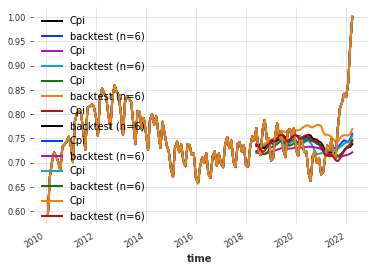

In [ ]:
# πρόβλεψη του πληθωρισμού με την χρήση κάθε διαθέσιμης χρονοσειράς 
# ως εξωτερική χρονοσειρά
for col in cols:

  external_series = TimeSeries.from_dataframe(greece_inflation, 'Date', col)
  brnn_no_cov = BlockRNNModel(input_chunk_length=30, output_chunk_length=10, n_rnn_layers=2)
  brnn_no_cov.fit(cpi_series, past_covariates=external_series, epochs=100, verbose=True)
  eval_model(brnn_no_cov, external_series)